In [1]:
import torch
from torch import nn

In [2]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

ae_dir = os.path.join(project_dir, 'modules/AutoEncoder')
if ae_dir not in sys.path:
    sys.path.append(ae_dir)

import numpy as np
import torch
import config

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torchvision.transforms import ToTensor

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False
        
def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  ToTensor()(meshgrid)
    else:
        assert False
        
    return net_input

# Data

In [4]:
from scipy.io import loadmat
mat = loadmat(os.path.join(config.DERMA_DATASET_DIR, 'train/P32_C1000.mat'))
X = mat['preProcessedImage'].astype(np.float64)

In [5]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(X, 6, maxit=1024, normalize=False,ATGP_init=True))
U_tensor = torch.unsqueeze(U.T, dim=0)
print('Endmember shape: {}'.format(U_tensor.shape))

Endmember shape: torch.Size([1, 116, 6])


In [8]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode

transform = Compose([
    ToTensor(),
    Resize((64,64), InterpolationMode.NEAREST)
])

In [9]:
X = torch.unsqueeze(transform(X), dim=0)
noisy_input = get_noise(X.shape[1], 'noise', X.shape[2:], noise_type='u')

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X.shape))

Z shape: torch.Size([1, 116, 64, 64])
HyperCube shape: torch.Size([1, 116, 64, 64])


In [10]:
from HySpecLab.unmixing import UnDIP

n_bands = X.shape[1]
n_endmembers = U.shape[0]

in_channels = [n_bands, 256]
out_channels = [32, 128]
skip_channels = [4, 8]

model = UnDIP(in_channels, out_channels, skip_channels, n_endmembers)

In [11]:
output = model(noisy_input)
output.shape

torch.Size([1, 6, 64, 64])

In [12]:
batch_size = output.shape[0]
w, h = output.shape[2:]
criterion = nn.MSELoss()
restoration = torch.matmul(U_tensor, output.flatten(start_dim=2)).reshape((batch_size, n_bands, w, h))

In [13]:
criterion(X, restoration)

tensor(0.0058, dtype=torch.float64, grad_fn=<MseLossBackward0>)

# Train

In [15]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

n_bands = X.shape[1]
w, h = X.shape[2:]

n_epoch = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.MSELoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

tb_writer = SummaryWriter('logs/test')
show_band_idx = np.linspace(0, X.shape[1]-1, num=16, dtype=np.int64)
target_imgs = torch.unsqueeze(X[0, show_band_idx], dim=1)
img_grid = make_grid(target_imgs)
tb_writer.add_image('Target', img_grid, 0)

noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    output = model(noisy_input)

    restoration = torch.matmul(U_tensor.to(device), output.flatten(start_dim=2)).reshape((1, n_bands, w, h))

    rest_imgs = torch.unsqueeze(restoration[0, show_band_idx], dim=1)
    img_grid = make_grid(rest_imgs)
    tb_writer.add_image('Output', img_grid, epoch)

    batch_loss = criterion(restoration, X.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

100%|██████████| 5000/5000 [04:33<00:00, 18.28epoch/s, tls=0.0008]


In [17]:
A = model(noisy_input)

In [ ]:
torch.save(A, 'Abundance.pt')

In [6]:
A = torch.load('Abundance.pt')

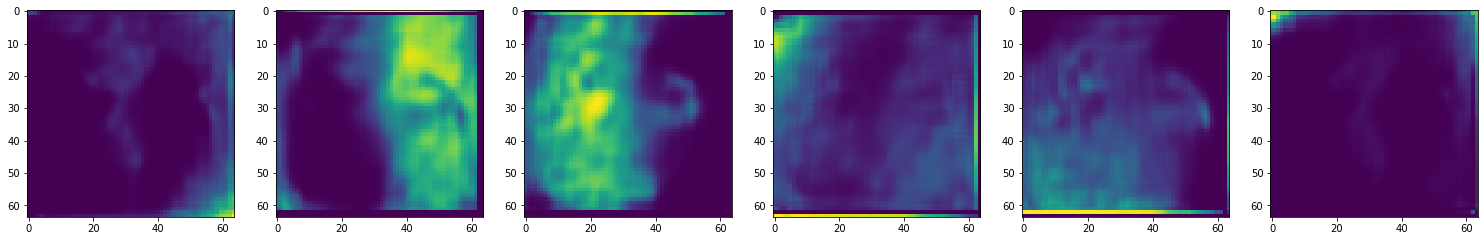

In [14]:
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt

A = A.cpu().detach()
fig, ax = plt.subplots(1,6, figsize=(26,9))
for i in range(len(A[0])):
    ax[i].imshow(A[0,i])

# Testing

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [ ]:
tb_writer = SummaryWriter('logs/test')

In [ ]:
idx = np.linspace(0, X.shape[1]-1, num=16, dtype=np.int64)
test = torch.unsqueeze(restoration[0, idx], dim=1)
target_imgs = torch.unsqueeze(X[0, idx], dim=1)
# idx

In [ ]:
img_grid = make_grid(test)
tb_writer.add_image('Output', img_grid, 0)

In [ ]:
img_grid = make_grid(target_imgs)
tb_writer.add_image('Target', img_grid, 0)

In [ ]:
X.min()